In [ ]:
!pip install pytorch_lightning

     |████████████████████████████████| 563kB 8.5MB/s 
     |████████████████████████████████| 276kB 22.3MB/s 
     |████████████████████████████████| 829kB 28.6MB/s 
     |████████████████████████████████| 92kB 9.3MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=cced04783e19773e8758f536c2e84f53fc260ed547ef82500eb356db8f19fa9d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=e9d7973d1ae9541e820e56e6cd25df8a6656be576f641b51ec0a610351736b02
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninst

In [ ]:
!pip install einops

In [ ]:
import numpy as np
import torch
from torch import nn as nn
import torchvision.transforms as transforms
import pytorch_lightning as pl
from einops import rearrange, repeat
from collections import OrderedDict

In [ ]:
import matplotlib.pyplot as plt
import torchvision.datasets as datasets

In [ ]:
B_16 = {
    'patch_size':(16,16),
    'hidden_size':768,
    'mlp_dim':3072,
    'num_heads':12,
    'num_layers':12,
    'attention_dropout_rate':0.0,
    'dropout_rate': 0.1,
} #representation_size?

In [ ]:
B_32 = {
    'patch_size':(32,32),
    'hidden_size':768,
    'mlp_dim':3072,
    'num_heads':12,
    'num_layers':12,
    'attention_dropout_rate':0.0,
    'dropout_rate': 0.1,
} 

In [ ]:
L_16 = {
    'patch_size':(16,16),
    'hidden_size':1024,
    'mlp_dim':4096,
    'num_heads':16,
    'num_layers':24,
    'attention_dropout_rate':0.0,
    'dropout_rate':0.1,
}

In [ ]:
L_32 = {
    'patch_size':(32,32),
    'hidden_size':1024,
    'mlp_dim':4096,
    'num_heads':16,
    'num_layers':24,
    'attention_dropout_rate':0.0,
    'dropout_rate':0.1,
}

In [ ]:
configs = {
    'B_16': B_16,
    'B_32': B_32,
    'L_16': L_16,
    'L_32': L_32
}

In [ ]:
#pretraining presets?

In [ ]:
fine_tuning_presets = {
    'ImageNet': {'lr':[0.003,0.01,0.03,0.06], 'batch_size':512, 'steps':20000},
    'CIFAR100': {'lr':[0.001,0.003,0.01,0.03], 'batch_size':512, 'steps':10000},
    'CIFAR10': {'lr':[0.001,0.003,0.01,0.03], 'batch_size':512, 'steps':10000},
    'Oxford-IIIT Pets': {'lr':[0.001,0.003,0.01,0.03], 'batch_size':512, 'steps':500},
    'Oxford Flowers-102': {'lr':[0.001,0.003,0.01,0.03], 'batch_size':512, 'steps':500},
    'VTAB': {'lr':[0.01], 'batch_size':512, 'steps':20000},
} #cosine lr decay, grad clipping at global norm 1, SGD with momentum 0.9,  

In [ ]:
architecture = 'B_16'
dataset = 'ImageNet'

In [ ]:
hparams = {}
mode = 'fine-tuning'  #REMOVE
if mode == 'fine-tuning':
  for k in (configs, fine_tuning_presets):
    if architecture in k.keys():
      hparams.update(k[architecture])
    if dataset in k.keys():
      hparams.update(k[dataset])
    hparams['optimizer'] = 'SGDm0.9'
    hparams['scheduler'] = 'cosine_lr_decay'
    #print(k,'\n')

In [ ]:
print(hparams.keys())

dict_keys(['patch_size', 'hidden_size', 'mlp_dim', 'num_heads', 'num_layers', 'attention_dropout_rate', 'dropout_rate', 'optimizer', 'scheduler', 'lr', 'batch_size', 'steps'])


In [ ]:
print(hparams.values())

dict_values([(16, 16), 768, 3072, 12, 12, 0.0, 0.1, 'SGDm0.9', 'cosine_lr_decay', [0.003, 0.01, 0.03, 0.06], 512, 20000])


Doubt: How to implement the linear projection, whose weights are actually (16,16,3,768) in Flax, however, Pytorch has different working of Linear layers

In [ ]:
sample =  torch.rand((196,16,16,3))
linear_layer = nn.Linear(768,768)
print(linear_layer(sample.view(196,-1)).shape)

torch.Size([196, 768])


In [ ]:
class MultiheadedSelfAttention(nn.Module):
    def __init__(self,embed_size,heads):
        super(MultiheadedSelfAttention,self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size should be divisible by num heads"

        self.query = nn.Linear(self.head_dim, self.head_dim)
        self.key = nn.Linear(self.head_dim, self.head_dim)
        self.value = nn.Linear(self.head_dim, self.head_dim)
        self.out = nn.Linear(heads*self.head_dim,embed_size)

    def forward(self, values, keys, query, mask):
        #no. of training examples in the batch
        N = query.shape[0]

        #corresponding src or target length 
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        #split embedding into self.heads pieces (one of the faster way to do this)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.value(values)  # (N, value_len, heads, head_dim)
        keys = self.key(keys)  # (N, key_len, heads, head_dim)
        queries = self.query(query)  # (N, query_len, heads, heads_dim)

        #einsum is multidimensional matrix multiplication 
        energy = torch.einsum("nqhd,nkhd->nhqk",[queries, keys])
        # energy represents the output of Q*K
        # queries shape: (N, query_len, heads, heads_dim)
        # keys shape: (N, keys_len, heads, heads_dim)

        #masking if required 
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        #calculating attention 
        attention = torch.softmax(energy/ (self.embed_size ** (1/2)), dim=3)

        #multiplying by the values 
        out = torch.einsum("nhql,nlhd->nqhd",[attention, values]).reshape(
            N, query_len, self.heads*self.head_dim
        )
        # attention shape: (N, heads, query_len, key_len)
        # values shape: (N, value_len, heads, heads_dim)
        # out shape: (N, query_len, heads, head_dim) then flatten last two dimension to get the final output

        out = self.out(out)
        return out 

In [ ]:
class TransformerBlock(nn.Module):  ##MODIFY      #CHECKED
    def __init__(self, embed_size, heads, mlp_dim, dropout):
        super(TransformerBlock,self).__init__()
        self.dropout = dropout
        self.LayerNorm_0 = nn.LayerNorm(embed_size)
        self.MultiHeadDotProductAttention_1 = MultiheadedSelfAttention(embed_size,heads)
        self.LayerNorm_2 = nn.LayerNorm(embed_size)

        #defining feed formward here instead of separate block 
        #forward expansion is an arbritary choice 4 in paper 
        self.MlpBlock_3= nn.Sequential(OrderedDict([
            ('Dense_0',nn.Linear(embed_size,mlp_dim)),
            ('gelu',nn.GELU()),
            ('dropout_0',nn.Dropout(dropout)),
            ('Dense_1',nn.Linear(mlp_dim,embed_size)),
            ('dropout_1',nn.Dropout(dropout))
        ]))
        

    def forward(self, value, key, query, mask):  #INCOMPLETE

        q = self.LayerNorm_0(query)
        k = self.LayerNorm_0(key)
        v = self.LayerNorm_0(value)
        #mask?
        attention = self.MultiHeadDotProductAttention_1(v, k, q, mask)
        attention = nn.Dropout(self.dropout)(attention)

        #skip connections as in paper to provide raw context
        attention = attention + query

        forward = self.LayerNorm_2(attention)
        #x = self.dropout(self.LayerNorm_0(attention + query))  #MISTAKE?
        forward = self.MlpBlock_3(forward)

        #skip connections as in paper to provide raw context
        #out = self.dropout(self.LayerNorm_2(attention + query))   #MISTAKE?
        out = attention + forward

        return out 

In [ ]:
class Encoder(nn.Module):
    def __init__(
        self,
        embed_size,
        num_layers, 
        heads,  #number of heads in Multiheaded Attention?
        mlp_dim,
        dropout,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.encoder_norm = nn.LayerNorm(embed_size)  #chkpt['Transformer']['encoder_norm']

        layers_dict = OrderedDict()
        for i in range(num_layers):
          layers_dict['encoderblock_'+str(i)] = TransformerBlock(
                  embed_size,
                  heads,
                  mlp_dim = mlp_dim,
                  dropout=dropout,
              )

        self.layers = nn.Sequential(layers_dict)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        print(x.shape)
        B, N, seq_length = x.shape   #Batch N = no. of tokens, seq_length = embedding size

        for layer in range(len(self.layers)):
            x = self.layers[0](x,x,x,mask)

        #for layer in self.layers:
        #    x = layer(x,x,x,mask)  #WTF?
        x = self.encoder_norm(x)

        out = x
        return out

In [ ]:
#TODO: 
'''
add 'assert' for checking whether input shape is correct
remove the hardcoded hparams and fit with entries of self.hparams dictionary

'''

"\nadd 'assert' for checking whether input shape is correct\nremove the hardcoded hparams and fit with entries of self.hparams dictionary\n\n"

In [ ]:
#CHECK
'''
1) If the torch.view(-1,16,16,3) divides the image into proper slices or not
2) If the 'embedding' parameter of checkpoint dict, i.e, the trainable linear projection is loaded properly as a torch.nn.Linear layer
UPDATE; 'embedding' is actually Conv2D of size (16,16) and stride (16,16), inp. channels = 3 and output channels = 768
(as it was originally for flax.nn.Linear layer)

3) If the 'key','value','query' and 'out' are loaded properly
4) How the final MLP block has actually two blocks with GELU activation
5) Where 'pre_logits' from the checkpoint dictionary fit into our model
6) If 'mask' fits in
7) Representation size??
'''

"\n1) If the torch.view(-1,16,16,3) divides the image into proper slices or not\n2) If the 'embedding' parameter of checkpoint dict, i.e, the trainable linear projection is loaded properly as a torch.nn.Linear layer\nUPDATE; 'embedding' is actually Conv2D of size (16,16) and stride (16,16), inp. channels = 3 and output channels = 768\n(as it was originally for flax.nn.Linear layer)\n\n3) If the 'key','value','query' and 'out' are loaded properly\n4) How the final MLP block has actually two blocks with GELU activation\n5) Where 'pre_logits' from the checkpoint dictionary fit into our model\n6) If 'mask' fits in\n7) Representation size??\n"

In [ ]:
class ViT(pl.LightningModule):
  def __init__(self,hparams, pretrained_path = None):
    super(ViT, self).__init__()
    self.patch_size = 16 #change to self.hparams.patch_size[0]

    #SAMPLE JUST ASSUMING THAT A SINGLE IMAGE IS PASSES, WHEREAS A BATCH WOULD BE PASSED IN REAL `forward` METHOD
    img = torch.rand((3,224,224))
    img = img.permute(1,2,0)
    print("img shape:",img.shape)
    img = img.reshape(-1,3,16,16)
    print("number of tokens:",img.shape[0])
    
    #trainable linear projection
    #self.embedding = nn.Linear(768,768,True) #output= 32x196x768 if batch size is 32?
    self.embedding = nn.Conv2d(3,768,(16,16),(16,16), padding_mode = 'zeros')
    self.patch_to_embedding = nn.Linear(768, 768)

    #self.lin_projection.data = self.loaded_weights['embedding']['kernel'].reshape(-1,768) where 768 is self.hparams['hidden_size']
    self.cls = nn.Parameter(data = torch.rand((1,1,768)))
    
    self.Transformer = Encoder(embed_size = 768, num_layers= 12, heads= 12, mlp_dim= 3072, dropout = 0.0)
    
    lin_proj = self.embedding(img).unsqueeze(0)
    print('lin proj shape:',lin_proj.shape)
    lin_proj = lin_proj.squeeze(3).squeeze(3)

    final_tokens = torch.cat((self.cls.data, lin_proj), dim=1)
    print("Final token size:", final_tokens.shape)

    self.pos_embedding = nn.Parameter(data = torch.rand((1,197,768)))
    self.use_conv = True
    self.pre_logits = nn.Linear(768,768)
    self.head = nn.Linear(768, 21843)

    result = self.head(self.pre_logits(self.Transformer(final_tokens+ self.pos_embedding)[:,0,:]))
    print(result.shape)

  def forward(self, img, mask = None):  
    
    p = self.patch_size
    #img = img.reshape(img.shape[0],-1,3,p,p)

    #using convolution or simple linear layer for projection to right dimensions 
    if (self.use_conv):                
        #img = rearrange(img, 'b c h w -> b (h w) c')
        x = self.embedding(img)
        print(x.shape)
        x = x.view(x.shape[0], -1, x.shape[1])
        print(x.shape)               
    else :
        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

    #getting batch and sequence length essentially
    b, n, _ = x.shape
    

    #this part appends the class tokens and adds positional embedding 
    #cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
    #x = torch.cat((cls_tokens, x), dim=1)
    batch_cls = torch.repeat_interleave(self.cls.data, 32, 0)
    final_tokens = torch.cat((batch_cls, x), dim=1)

    #positions = torch.arange(0, n + 1).expand(N, n + 1).to(self.device)
    #x = self.dropout(x + self.pos_embedding(positions))
    #as implemented in a default way!
    
    #x += self.pos_embedding[:, :(n + 1)]
    batch_pos_embedding = torch.repeat_interleave(self.pos_embedding, 32, 0)
    print(batch_pos_embedding.shape)

    final_tokens = final_tokens + batch_pos_embedding

    #calling the transformer here!
    classes = self.head(self.pre_logits(self.Transformer(final_tokens)[:,0,:]))

    
    #x = self.transformer(x, mask)
    #x = self.to_cls_token(x[:, 0])
    #return self.classifier(x)

    return classes

In [ ]:
model = ViT(hparams)

img shape: torch.Size([224, 224, 3])
number of tokens: 196
lin proj shape: torch.Size([1, 196, 768, 1, 1])
Final token size: torch.Size([1, 197, 768])
torch.Size([1, 197, 768])
torch.Size([1, 21843])


In [ ]:
img = torch.rand((32,3,224,224))
print(model(img).shape)
#SUCCESS

torch.Size([32, 768, 14, 14])
torch.Size([32, 196, 768])
torch.Size([32, 197, 768])
torch.Size([32, 197, 768])
torch.Size([32, 21843])


In [ ]:
chkpt = load('/content/drive/My Drive/imagenet21k_ViT-B_16.npz')

Sandbox

In [ ]:
print(model.Transformer.layers[0])

In [ ]:
my_str = 'ayy.beee.siii'
print(len(my_str.split('.')))

3


In [ ]:
model.Transformer.layers.encoderblock_0.LayerNorm_0

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

In [ ]:
my_obj = nn.LayerNorm(768)


In [ ]:
print(getattr(model,'embedding').weight.data)

Loading model checkpoints into out Lightning Model

In [ ]:
for name, param in model.named_parameters():
  name = name.split('.')
  if len(name) == 1:   #for 'cls' and 'pos_embedding'
    if name[0] == 'pos_embedding':
      getattr(model, name[0]).data = torch.Tensor(chkpt['Transformer']['posembed_input'][name[0]])
    elif name[0] == 'cls':
      getattr(model, name[0]).data = torch.Tensor(chkpt[name[0]])              
  elif len(name) == 2 and 'patch_to_embedding' not in name:  #for 'pre_logits', 'head', 'embedding', as 'patch_to_embedding' is additionally defined by us
    getattr(model,name[0]).weight.data = torch.Tensor(chkpt[name[0]]['kernel'])
    getattr(model,name[0]).bias.data = torch.Tensor(chkpt[name[0]]['bias'])
  elif len(name) == 3: #for 'Transformer.encoder_norm'
    getattr(getattr(model,name[0]),name[1]).weight.data = torch.Tensor(chkpt[name[0]][name[1]]['scale'])
    getattr(getattr(model,name[0]),name[1]).bias.data = torch.Tensor(chkpt[name[0]][name[1]]['bias'])
  elif len(name) == 5: #for Transformer.layers.encoderblock_i.LayerNorm0 or 2, i.e, name[3] guaranteed to be 'LayerNorm_0' or 'LayerNorm_2'
    getattr(getattr(getattr(getattr(model,name[0]),name[1]),name[2]),name[3]).weight.data = torch.Tensor(chkpt[name[0]][name[2]][name[3]]['scale'])
    getattr(getattr(getattr(getattr(model,name[0]),name[1]),name[2]),name[3]).bias.data = torch.Tensor(chkpt[name[0]][name[2]][name[3]]['bias'])
  elif len(name) == 6:
    getattr(getattr(getattr(getattr(getattr(model,name[0]),name[1]),name[2]),name[3]),name[4]).weight.data = torch.Tensor(chkpt[name[0]][name[2]][name[3]][name[4]]['kernel'])
    getattr(getattr(getattr(getattr(getattr(model,name[0]),name[1]),name[2]),name[3]),name[4]).bias.data = torch.Tensor(chkpt[name[0]][name[2]][name[3]][name[4]]['bias'])
  else:
    print(len(name))
    print(name)
    print('Understandable, have a nice day')

2
['patch_to_embedding', 'weight']
Understandable, have a nice day
2
['patch_to_embedding', 'bias']
Understandable, have a nice day


Testing whether the loaded weights are correct

In [ ]:
%pwd

'/content/vision_transformer'

In [ ]:
%cd '/content'

/content


In [ ]:
%pwd

'/content'

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#https://storage.googleapis.com/bit_models/imagenet21k_wordnet_ids.txt
from nltk.corpus import wordnet as wn
wordnet_ids = open("/content/imagenet21k_wordnet_ids.txt", "r").readlines()
wordnet_ids = [x.strip() for x in wordnet_ids]
wordnet_ids = [int(x[1:]) for x in wordnet_ids]

print(wn.synset_from_pos_and_offset('n', wordnet_ids[21800]))

'''
for index in torch.argsort(output, descending=True)[:10]:
    print(wn.synset_from_pos_and_offset('n', wordnet_ids[int(index)]))
'''

Synset('pantothenic_acid.n.01')


"\nfor index in torch.argsort(output, descending=True)[:10]:\n    print(wn.synset_from_pos_and_offset('n', wordnet_ids[int(index)]))\n"

In [ ]:
make_tensor = transforms.Compose([
  transforms.ToTensor()
])

In [ ]:
dataset = datasets.CIFAR10(root='.', transform= make_tensor, download = True)

Extracting ./cifar-10-python.tar.gz to .


In [ ]:
dataloader = torch.utils.data.DataLoader(dataset,batch_size = 32)

In [ ]:
class_to_idx = dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(type(idx_to_class))
print(idx_to_class.keys())
print(idx_to_class.values())

<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
dict_values(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])


torch.Size([32, 3, 32, 32])
torch.Size([32])


TypeError: ignored

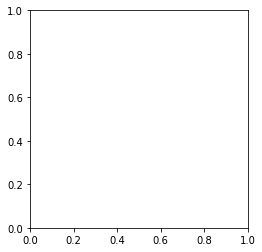

In [ ]:
i = 0
for batch, labels in dataloader:
  i = i + 1
  print(batch.shape)
  print(labels.shape)
  plt.imshow(batch[0].permute)
  if i == 6:
    break

In [ ]:
for name in chkpt['Transformer'].keys():
  print(name,'\'s:',chkpt['Transformer'][name].keys())
  for x in chkpt['Transformer'][name].keys():
    if (type(chkpt['Transformer'][name][x]) is not dict):
      print('Dimension of', x, ':', chkpt['Transformer'][name][x].shape)
    else:
      for y in chkpt['Transformer'][name][x].keys():
        if (type(chkpt['Transformer'][name][x][y])) is not dict:
          print('Dimension of',x,'\'s',y,'is ', chkpt['Transformer'][name][x][y].shape)
        else:
          print('\n',x,'\'s',y,'dictionary is ', chkpt['Transformer'][name][x][y].keys())
          print('------->')
          for z in chkpt['Transformer'][name][x][y].keys():
            print('\t',z,'dictionary\'s entries\' dims are:',chkpt['Transformer'][name][x][y][z].shape)
  print('-----------------')

In [ ]:
for name, param in model.named_parameters():
  print(name)

cls
pos_embedding
embedding.weight
embedding.bias
patch_to_embedding.weight
patch_to_embedding.bias
Transformer.encoder_norm.weight
Transformer.encoder_norm.bias
Transformer.layers.encoderblock_0.LayerNorm_0.weight
Transformer.layers.encoderblock_0.LayerNorm_0.bias
Transformer.layers.encoderblock_0.MultiHeadDotProductAttention_1.query.weight
Transformer.layers.encoderblock_0.MultiHeadDotProductAttention_1.query.bias
Transformer.layers.encoderblock_0.MultiHeadDotProductAttention_1.key.weight
Transformer.layers.encoderblock_0.MultiHeadDotProductAttention_1.key.bias
Transformer.layers.encoderblock_0.MultiHeadDotProductAttention_1.value.weight
Transformer.layers.encoderblock_0.MultiHeadDotProductAttention_1.value.bias
Transformer.layers.encoderblock_0.MultiHeadDotProductAttention_1.out.weight
Transformer.layers.encoderblock_0.MultiHeadDotProductAttention_1.out.bias
Transformer.layers.encoderblock_0.LayerNorm_2.weight
Transformer.layers.encoderblock_0.LayerNorm_2.bias
Transformer.layers.enc

In [ ]:
!pip install flax
!pip install ml_collections
!git clone https://github.com/google-research/vision_transformer.git

In [ ]:
%cd vision_transformer/

/content/vision_transformer


In [ ]:
from vit_jax import checkpoint_test, checkpoint
from vit_jax.checkpoint_test import *
from vit_jax.checkpoint import *

In [ ]:
chkpt = load('/content/drive/My Drive/imagenet21k_ViT-B_16.npz')

In [ ]:
chkpt.keys()

dict_keys(['cls', 'Transformer', 'embedding', 'head', 'pre_logits'])

In [ ]:
chkpt['Transformer'].keys()

dict_keys(['encoder_norm', 'encoderblock_0', 'encoderblock_1', 'encoderblock_10', 'encoderblock_11', 'encoderblock_2', 'encoderblock_3', 'encoderblock_4', 'encoderblock_5', 'encoderblock_6', 'encoderblock_7', 'encoderblock_8', 'encoderblock_9', 'posembed_input'])

In [ ]:
for name in chkpt['Transformer'].keys():
  print('----------------')
  print(name,'\'s:',chkpt['Transformer'][name].keys())
  print('>>')
  for x in chkpt['Transformer'][name].keys():
    if (type(chkpt['Transformer'][name][x]) is not dict):
      print('Dimension of', x, ':', chkpt['Transformer'][name][x].shape)
    else:
      for y in chkpt['Transformer'][name][x].keys():
        if (type(chkpt['Transformer'][name][x][y])) is not dict:
          print('Dimension of',x,'\'s',y,'is ', chkpt['Transformer'][name][x][y].shape)
        else:
          print('\n',x,'\'s',y,'dictionary is ', chkpt['Transformer'][name][x][y].keys())
          print('------->')
          for z in chkpt['Transformer'][name][x][y].keys():
            print('\t',z,'dictionary\'s entries\' dims are:',chkpt['Transformer'][name][x][y][z].shape)
  print('-----------------')

----------------
encoder_norm 's: dict_keys(['bias', 'scale'])
>>
Dimension of bias : (768,)
Dimension of scale : (768,)
-----------------
----------------
encoderblock_0 's: dict_keys(['LayerNorm_0', 'LayerNorm_2', 'MlpBlock_3', 'MultiHeadDotProductAttention_1'])
>>
Dimension of LayerNorm_0 's bias is  (768,)
Dimension of LayerNorm_0 's scale is  (768,)
Dimension of LayerNorm_2 's bias is  (768,)
Dimension of LayerNorm_2 's scale is  (768,)

 MlpBlock_3 's Dense_0 dictionary is  dict_keys(['bias', 'kernel'])
------->
	 bias dictionary's entries' dims are: (3072,)
	 kernel dictionary's entries' dims are: (768, 3072)

 MlpBlock_3 's Dense_1 dictionary is  dict_keys(['bias', 'kernel'])
------->
	 bias dictionary's entries' dims are: (768,)
	 kernel dictionary's entries' dims are: (3072, 768)

 MultiHeadDotProductAttention_1 's key dictionary is  dict_keys(['bias', 'kernel'])
------->
	 bias dictionary's entries' dims are: (12, 64)
	 kernel dictionary's entries' dims are: (768, 12, 64)

 

In [ ]:
for x in chkpt['embedding'].values():
  print(x.shape)

(768,)
(16, 16, 3, 768)


In [ ]:
chkpt['pre_logits'].keys()

dict_keys(['bias', 'kernel'])